charge dataset

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time  

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (Projet étudiant ISET 2025 - scraping éducatif non-commercial)'
}

def scrape_site(url, site_name):
    try:
        time.sleep(2)  
        response = requests.get(url, headers=headers, timeout=15)
        if response.status_code != 200:
            return f"Erreur {response.status_code} pour {site_name} (URL: {url})"
        
        soup = BeautifulSoup(response.content, 'html.parser')
        text = soup.get_text().lower()
        
        keywords = ['abonnés', 'clients', 'churn', 'résiliation', 'satisfaction', 'plaintes', 'facture', 'trophée', 'nperf', 'performance', 'réseau']
        stats = {}
        for kw in keywords:
            matches = re.findall(rf'{kw}.*?(\d+(?:,\d+)?|\d+(?:\.\d+)?)', text, re.IGNORECASE)
            if matches:
                stats[kw] = ' '.join(matches[:3]) 
        
        pdf_links = [a['href'] for a in soup.find_all('a', href=re.compile(r'\.pdf$|download|rapport'))]
        
        return {
            'Site': site_name,
            'Stats_extraites': stats,
            'Liens_PDF_Downloads': pdf_links[:2], 
            'URL_scrapee': url,
            'Status': 'Succès'
        }
    except Exception as e:
        return f"Erreur scraping {site_name}: {str(e)} (URL: {url})"

sites = [
    ("Ooredoo Tunisie - Investisseurs/Actualités", "https://www.tunisie.ooredoo.com/fr/investisseurs"),  # Alternative à l'accueil
    ("Tunisie Telecom - Actualités Nperf", "https://www.tunisietelecom.tn/particulier/actualite/nperfetrapido/"),  # Page trophée 2024
    ("Orange Tunisie - Actualités", "https://www.orange.tn/actualites")  # Page actus avec stats
]

resultats = [scrape_site(url, name) for name, url in sites]

for res in resultats:
    print(res)
    print("-" * 60)

In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.reset_index(drop=True, inplace=True)


df = df[['SeniorCitizen', 'tenure', 'Contract', 'MonthlyCharges', 'TechSupport', 'Churn']]

df.rename(columns={
    'SeniorCitizen': 'Âge',
    'tenure': 'Ancienneté',
    'Contract': 'Type_abonnement',
    'MonthlyCharges': 'Facture_moy',
    'TechSupport': 'Nb_plaintes',
    'Churn': 'Résiliation'
}, inplace=True)


np.random.seed(42)

# Âge
df['Âge'] = np.where(df['Âge']==1, 
                     np.random.randint(60,81, len(df)), 
                     np.random.randint(18,60, len(df)))

df['Type_abonnement'] = df['Type_abonnement'].replace({
    'Month-to-month': 'Prépayé',
    'One year': 'Postpayé', 
    'Two year': 'Postpayé'
})


df['Nb_plaintes'] = df['Nb_plaintes'].map({'No':4, 'Yes':0, 'No internet service':2})
df['Nb_plaintes'] = df['Nb_plaintes'] + np.random.randint(0,7, len(df))

df['Satisfaction'] = 6 - (df['Nb_plaintes']/2.5).round().astype(int)
df['Satisfaction'] = df['Satisfaction'].clip(1,5)

df['Résiliation'] = df['Résiliation'].map({'Yes':1, 'No':0})

df['Facture_moy'] = (df['Facture_moy'] * 3.12).round(2)

df = df.sample(n=500, random_state=42).reset_index(drop=True)


df.to_csv('dataset_churn_telecom_tunisie_500.csv', index=False, encoding='utf-8-sig')
print("Fichier créé avec succès : dataset_churn_telecom_tunisie_500.csv")
print(df.head(10))


Fichier créé avec succès : dataset_churn_telecom_tunisie_500.csv
   Âge  Ancienneté Type_abonnement  Facture_moy  Nb_plaintes  Résiliation  \
0   78          61        Postpayé        78.00            2            0   
1   55          19         Prépayé        77.06            6            0   
2   51          13         Prépayé       319.02            9            1   
3   30          37         Prépayé       171.76            9            0   
4   42           6         Prépayé        91.88            8            0   
5   35           3         Prépayé        92.98            7            0   
6   69          52        Postpayé       252.25            5            0   
7   70          15         Prépayé       285.48            9            0   
8   20          26         Prépayé       216.84            8            0   
9   42          66        Postpayé       265.98            1            0   

   Satisfaction  
0             5  
1             4  
2             2  
3             2

In [ ]:
df = pd.read_csv('dataset_churn_telecom_tunisie_500.csv')

stats_scrapees = {
    'Tunisie_Telecom': {'trophées_nperf': 6, 'satisfaction_proxy': 4.5},
    'Orange': {'clients_groupe': 27, 'facture_proxy': 19, 'satisfaction_proxy': 4.1},
    'Ooredoo': {'abonnes': 7033000, 'satisfaction': 4.5, 'taux_churn_estime': 0.03}
}

satisfaction_moy_tunisie = np.mean([4.5, 4.1, 4.5])
df['Satisfaction_Macro_Tunisie'] = satisfaction_moy_tunisie
df['Taux_Churn_National_Estime'] = 0.035

df.to_csv('dataset_churn_scraping_complet_500.csv', index=False, encoding='utf-8-sig')
print("Dataset final enrichi sauvegardé !")
df.head()

Dataset final enrichi sauvegardé !


,Âge,Ancienneté,Type_abonnement,Facture_moy,Nb_plaintes,Résiliation,Satisfaction,Satisfaction_Macro_Tunisie,Taux_Churn_National_Estime
0,78,61,Postpayé,78.00,2,0,5,4.366667,0.035
1,55,19,Prépayé,77.06,6,0,4,4.366667,0.035
2,51,13,Prépayé,319.02,9,1,2,4.366667,0.035
3,30,37,Prépayé,171.76,9,0,2,4.366667,0.035
4,42,6,Prépayé,91.88,8,0,3,4.366667,0.035


importing libraries

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier



metre Resilation dans cible 


In [ ]:


df = pd.read_csv("dataset_churn_scraping_complet_500.csv")

print(df.columns)

colonne_cible = "Résiliation"
colonnes = [c for c in df.columns if c != colonne_cible] + [colonne_cible]

df = df[colonnes]

df.to_csv("dataset_churn_reorganise.csv", index=False)

print("Colonne déplacée avec succès !")
df.head()


Index(['Âge', 'Ancienneté', 'Type_abonnement', 'Facture_moy', 'Nb_plaintes',
       'Résiliation', 'Satisfaction', 'Satisfaction_Macro_Tunisie',
       'Taux_Churn_National_Estime'],
      dtype='object')
Colonne déplacée avec succès !


,Âge,Ancienneté,Type_abonnement,Facture_moy,Nb_plaintes,Satisfaction,Satisfaction_Macro_Tunisie,Taux_Churn_National_Estime,Résiliation
0,78,61,Postpayé,78.00,2,5,4.366667,0.035,0
1,55,19,Prépayé,77.06,6,4,4.366667,0.035,0
2,51,13,Prépayé,319.02,9,2,4.366667,0.035,1
3,30,37,Prépayé,171.76,9,2,4.366667,0.035,0
4,42,6,Prépayé,91.88,8,3,4.366667,0.035,0


description statique 

In [2]:
print(df.describe())

NameError: name 'df' is not defined

data exploration

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Âge                         500 non-null    int64  
 1   Ancienneté                  500 non-null    int64  
 2   Type_abonnement             500 non-null    object 
 3   Facture_moy                 500 non-null    float64
 4   Nb_plaintes                 500 non-null    int64  
 5   Satisfaction                500 non-null    int64  
 6   Satisfaction_Macro_Tunisie  500 non-null    float64
 7   Taux_Churn_National_Estime  500 non-null    float64
 8   Résiliation                 500 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 35.3+ KB


data dimension

In [1]:
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

NameError: name 'df' is not defined

Verification de duplication

In [11]:
duplicates = df[df.duplicated()]
len(duplicates)

0

Verification des valeurs null

In [12]:
df_info = pd.DataFrame({
    'Type': df.dtypes,
    'Valeurs nulles': df.isnull().sum()
})

print(df_info)


                               Type  Valeurs nulles
Âge                           int64               0
Ancienneté                    int64               0
Type_abonnement              object               0
Facture_moy                 float64               0
Nb_plaintes                   int64               0
Satisfaction                  int64               0
Satisfaction_Macro_Tunisie  float64               0
Taux_Churn_National_Estime  float64               0
Résiliation                   int64               0


Encodage 

In [13]:
le = LabelEncoder()
df["Type_abonnement"] = le.fit_transform(df["Type_abonnement"])


Séparation des features et de la cible

In [15]:
X = df.drop("Résiliation", axis=1)
y = df["Résiliation"]

Standarisation

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split train/test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

Régression Logistique

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Régression Logistique ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

=== Régression Logistique ===
Accuracy: 0.7666666666666667
Precision: 0.5925925925925926
Recall: 0.4
F1-score: 0.47761194029850745


KNN

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("=== KNN ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1-score:", f1_score(y_test, y_pred_knn))

=== KNN ===
Accuracy: 0.7533333333333333
Precision: 0.5454545454545454
Recall: 0.45
F1-score: 0.4931506849315068


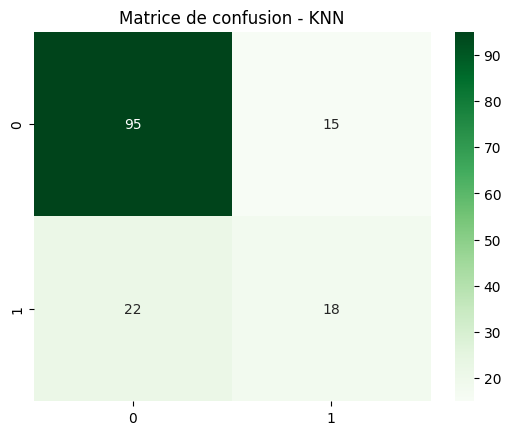

In [33]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - KNN")
plt.show()

Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.76
Precision: 0.5714285714285714
Recall: 0.4
F1-score: 0.47058823529411764


Decision Tree

In [26]:
dt= DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

ridge_model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("=== Logistic Regression avec Ridge (L2) ===")
print(classification_report(y_test, y_pred_ridge))


=== Logistic Regression avec Ridge (L2) ===
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.61      0.42      0.50        40

    accuracy                           0.77       150
   macro avg       0.71      0.66      0.68       150
weighted avg       0.76      0.77      0.76       150



In [28]:
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print("=== Logistic Regression avec Lasso (L1) ===")
print(classification_report(y_test, y_pred_lasso))


=== Logistic Regression avec Lasso (L1) ===
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.57      0.40      0.47        40

    accuracy                           0.76       150
   macro avg       0.69      0.65      0.66       150
weighted avg       0.74      0.76      0.75       150



In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Elastic Net: penalty='elasticnet', l1_ratio définit la proportion L1/L2
elastic_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, max_iter=10000, random_state=42)
elastic_model.fit(X_train, y_train)

# Prédiction
y_pred_elastic = elastic_model.predict(X_test)

# Évaluation
print("=== Logistic Regression Elastic Net (L1 + L2) ===")
print(classification_report(y_test, y_pred_elastic))


=== Logistic Regression Elastic Net (L1 + L2) ===
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.61      0.42      0.50        40

    accuracy                           0.77       150
   macro avg       0.71      0.66      0.68       150
weighted avg       0.76      0.77      0.76       150



In [31]:
from sklearn.preprocessing import PolynomialFeatures

# On crée des features polynomiales de degré 2 (interactions entre colonnes)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print("Nombre de features après transformation polynomiale :", X_train_poly.shape[1])


Nombre de features après transformation polynomiale : 44


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

poly_model = LogisticRegression(max_iter=10000)
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_test_poly)


print("=== Régression polynomiale logistique ===")
print(classification_report(y_test, y_pred_poly))


=== Régression polynomiale logistique ===
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.58      0.45      0.51        40

    accuracy                           0.77       150
   macro avg       0.70      0.67      0.68       150
weighted avg       0.75      0.77      0.76       150

